# Data Exploration and Analysis on MongoDB Database

In this notebook, we will explore and analyze a dataset of purchase orders stored in MongoDB. The task includes data loading, exploration, missing value analysis, and the aggregation of total money spent by fiscal year.

### **Note:**
Ensure that **MongoDB** is installed and running on your system before executing the code. You can download and install MongoDB from the official website: [MongoDB Installation Guide](https://www.mongodb.com/docs/manual/installation/).


## 1. Data Preprocessing & MongoDB Insertion
In this step, we will load the dataset, clean it (remove unwanted characters from price colunmns), and insert it into MongoDB for further exploration.



In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np

# Load dataset
file_path = r"C:\Users\alikh\Downloads\PURCHASE ORDER DATA EXTRACT 2012-2015_0.csv"
df = pd.read_csv(file_path)

# Clean up the 'Total Price' and 'Unit Price' columns
df['Total Price'] = df['Total Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['Unit Price'] = df['Unit Price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["LargePurchases"]
collection = db["SCPRS"]

# Insert data into MongoDB
collection.insert_many(df.to_dict('records'))
print("Data loaded successfully.")


Data loaded successfully.


## 2. Exploring the Dataset Structure

Let's take a quick look at the size and the structure of the dataset, including the column names, their types, and some examples of the data.


In [2]:
total_records = collection.count_documents({})
print(f"Total number of records in the dataset: {total_records}")

# Fetch sample records from MongoDB
sample_records = collection.find().limit(5)  # Fetch 5 records

# Initialize a dictionary to hold the column names and examples
column_data = {}

# Iterate over each record in the sample
for record in sample_records:
    for field, value in record.items():
        # Skip None or NaN values
        if value is None or (isinstance(value, float) and value != value):  # NaN check
            continue
        
        if field not in column_data:
            column_data[field] = {'type': type(value).__name__, 'examples': [value]}
        else:
            # Add the value to examples only if it's not already included
            if value not in column_data[field]['examples']:
                column_data[field]['examples'].append(value)

# Now, print the column names, their types, and 3 examples
for field, data in column_data.items():
    field_type = data['type']
    examples = data['examples'][:3]  # Get up to 3 examples
    print(f"Column: {field}")
    print(f"  Type: {field_type}")
    print(f"  Examples: {examples}")
    print("-" * 50)


Total number of records in the dataset: 346018
Column: _id
  Type: ObjectId
  Examples: [ObjectId('6753a6d070c06a386fef20b4'), ObjectId('6753a6d070c06a386fef20b5'), ObjectId('6753a6d070c06a386fef20b6')]
--------------------------------------------------
Column: Creation Date
  Type: str
  Examples: ['08/27/2013', '01/29/2014', '11/01/2013']
--------------------------------------------------
Column: Fiscal Year
  Type: str
  Examples: ['2013-2014']
--------------------------------------------------
Column: LPA Number
  Type: str
  Examples: ['7-12-70-26', '1-10-75-60A']
--------------------------------------------------
Column: Purchase Order Number
  Type: str
  Examples: ['REQ0011118', 'REQ0011932', 'REQ0011476']
--------------------------------------------------
Column: Requisition Number
  Type: str
  Examples: ['REQ0011118', 'REQ0011932', 'REQ0011476']
--------------------------------------------------
Column: Acquisition Type
  Type: str
  Examples: ['IT Goods', 'NON-IT Goods', 'I

The output reveals that the dataset has total number of records: 346018, and it contains diverse column types, including strings (e.g., 'Fiscal Year', 'Item Name') and numerics (e.g., 'Total Price', 'Quantity'), with some fields having consistent examples, while others, like 'Supplier Qualifications' and 'Location', contain more varied or sparse data.

## 3. Missing Value Analysis

In this section, we will identify and visualize the missing values across the dataset using MongoDB aggregation pipeline.


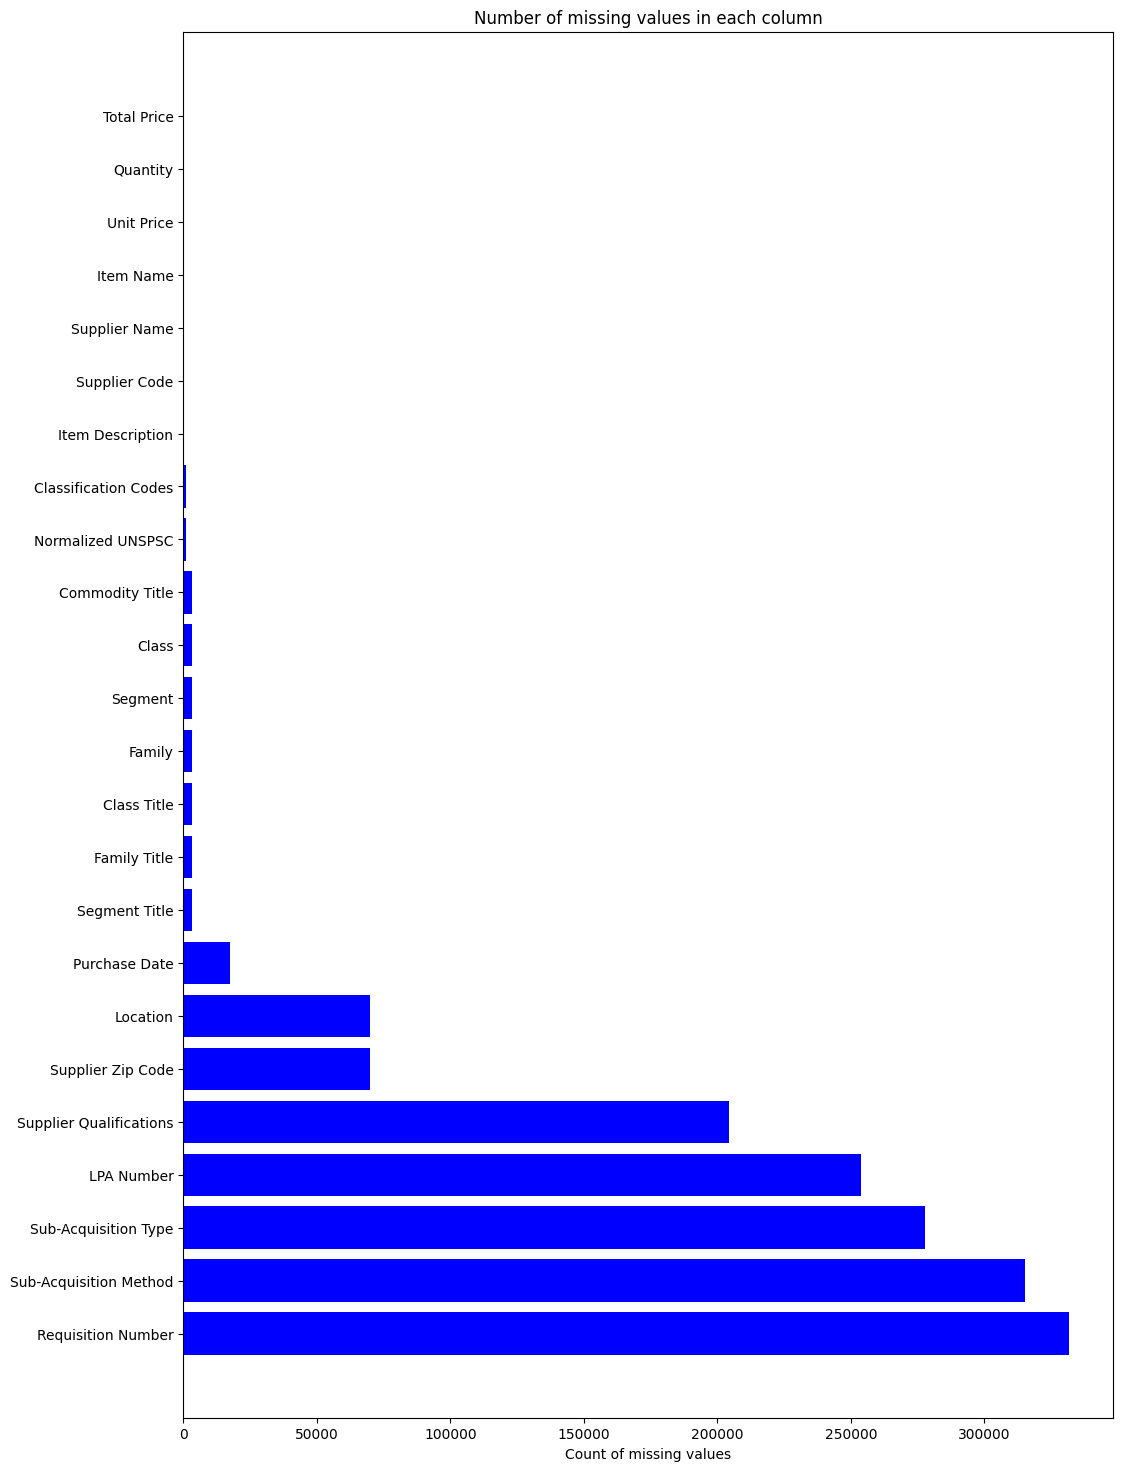

In [3]:
import matplotlib.pyplot as plt

# Find missing values using MongoDB
pipeline = [
    {
        "$project": {
            "columns": {
                "$objectToArray": "$$ROOT"  # Converts document fields into an array of key-value pairs
            }
        }
    },
    {
        "$unwind": "$columns"  # Flattens the array
    },
    {
        "$group": {
            "_id": "$columns.k",  # Groups by field name (key)
            "missing_count": {
                "$sum": {
                    "$cond": [
                        {"$or": [
                            {"$eq": ["$columns.v", None]},  # Check for None
                            {"$eq": ["$columns.v", float('nan')]}  # Check for NaN
                        ]}, 1, 0
                    ]
                }
            }
        }
    },
    {"$sort": {"missing_count": -1}}  # Sort by missing count in descending order
]

missing_data = list(collection.aggregate(pipeline))

# Convert results to pandas DataFrame
missing_df = pd.DataFrame(missing_data)
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]

# Visualize missing values
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12, 18))
rects = ax.barh(ind, missing_df['missing_count'].values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df['column_name'].values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


The missing values analysis shows that several columns, such as 'Requisition Number' and 'Sub-Acquisition Method', have significant missing data, but cleaning is not necessary as the dataset can still provide valuable insights without requiring imputation, especially if these columns are not critical to the analysis at hand.


## 4. Example of EDA: Total Money Spent by Fiscal Year
This example demonstrates how to aggregate and visualize total money spent by fiscal year as part of Exploratory Data Analysis (EDA). This is just one way to summarize and explore the dataset.


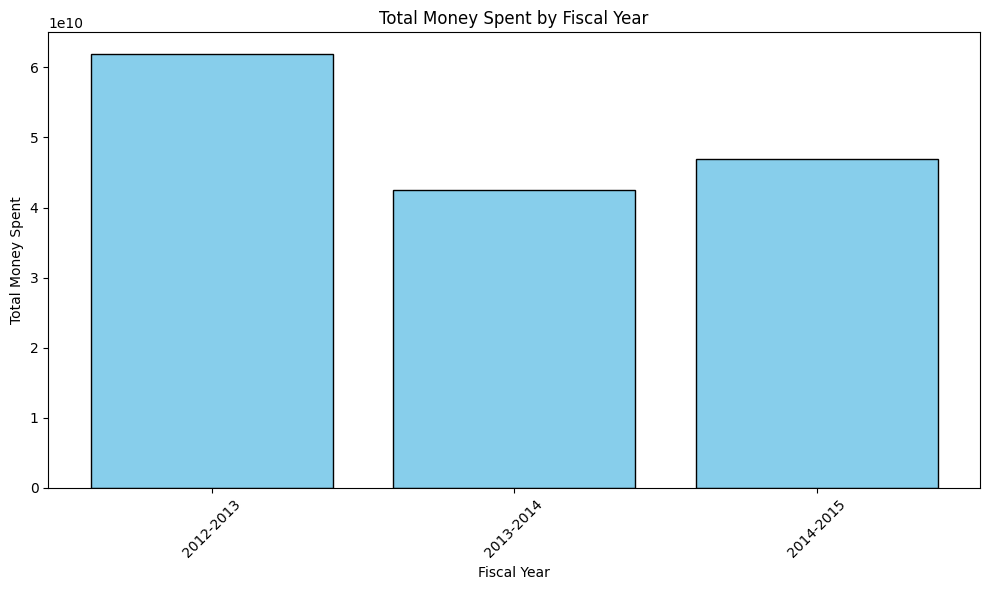

In [4]:
# MongoDB Aggregation Pipeline to sum total money spent by Fiscal Year
pipeline = [
    {
        "$match": {
            "Total Price": {"$ne": None, "$ne": float("NaN")}  # Exclude NaN and None values
        }
    },
    {
        "$group": {
            "_id": "$Fiscal Year",  # Group by Fiscal Year
            "total_spent": {"$sum": "$Total Price"}  # Sum of Total_Price
        }
    },
    {"$sort": {"_id": 1}}  # Sort by Fiscal Year in ascending order
]

# Execute the aggregation
result = list(collection.aggregate(pipeline))

# Prepare data for plotting
fiscal_years = [record["_id"] for record in result]
total_spent = [record["total_spent"] for record in result]

# Plotting the total spent money by fiscal year
plt.figure(figsize=(10, 6))
plt.bar(fiscal_years, total_spent, color='skyblue', edgecolor='black')
plt.xlabel("Fiscal Year")
plt.ylabel("Total Money Spent")
plt.title("Total Money Spent by Fiscal Year")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The output reveals a significant drop in total spending from 2012-2013 to 2013-2014, followed by a slight increase in 2014-2015, indicating potential changes in purchasing patterns or budget allocations across these fiscal years.